In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from config import DB_NAME, DB_URL, DB_PORT, DB_NAME, USERNAME, PASSWORD

# Import and Transform Data

In [2]:
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = USERNAME,
    password = PASSWORD,
    host = DB_URL,
    port = DB_PORT,
    database = DB_NAME
)

engine = create_engine(engine_string)

In [3]:
# Pull tables from database.
# !!! Note read_sql_table() requires sqlalchemy v1.4
sparse_covid_df = pd.read_sql_table('sparse_county_covid',engine).drop(columns=['index'])
dense_covid_df = pd.read_sql_table('dense_county_covid',engine).drop(columns=['index'])
weather_df = pd.read_sql_table('county_weather',engine).drop(columns=['index'])
county_df = pd.read_sql_table('county_pop',engine)

In [4]:
#####################################################################
### !!! To be removed once database is updated
#####################################################################
# Drop harrisonburg county
dense_covid_df = dense_covid_df[dense_covid_df['county'] != 'harrisonburg']

In [5]:
# Add past_delta14 columns to sparse and dense counties
sparse_covid_df['past_delta14'] = pd.Series(dtype=int)
dense_covid_df['past_delta14'] = pd.Series(dtype=int)

# Sparse county past_delta_14
for i in range(14,len(sparse_covid_df.index)):

    # Set past_delta_14
    past_cases = sparse_covid_df.iloc[i-14,3]
    present_cases = sparse_covid_df.iloc[i,3]
    delta14 = present_cases - past_cases

    sparse_covid_df.iloc[i,7] = delta14

# Dense county past delta14
for i in range(14,len(dense_covid_df.index)):

    # Set past_delta_14
    past_cases = dense_covid_df.iloc[i-14,3]
    present_cases = dense_covid_df.iloc[i,3]
    delta14 = present_cases - past_cases

    dense_covid_df.iloc[i,7] = delta14

In [6]:
# Sort weather data according to the sparse or dense county sets
sparse_counties = sparse_covid_df['county'].unique()
dense_counties = dense_covid_df['county'].unique()

# Sort weather for each set
sparse_weather_df = weather_df[weather_df['county'].isin(sparse_counties)]
dense_weather_df = weather_df[weather_df['county'].isin(dense_counties)]

# Sort county data for each set
sparse_county_df = county_df[county_df['county'].isin(sparse_counties)]
dense_county_df = county_df[county_df['county'].isin(dense_counties)]

In [7]:
# Merge weather data on sparse and dense covid data
sparse_weather_covid_df = sparse_covid_df.merge(sparse_weather_df,on=['date','county'])
dense_weather_covid_df = dense_covid_df.merge(dense_weather_df,on=['date','county'])

In [8]:
# Merge county data on sparse and dense data
sparse_weather_covid_county_df = sparse_weather_covid_df.merge(county_df,on=['county'])
dense_weather_covid_county_df = dense_weather_covid_df.merge(county_df,on=['county'])

In [9]:
# Set rows to keep
# Set Feature Categories
weather_features = ['temp_mean(c)','precip_sum(mm)','wind_max(km/h)','min_humidity(%)','max_humidity(%)','mean_humidity(%)']
county_features = ['total_pop','pop_dens(/sqmi)','avg_household']
covid_features = ['new_cases','past_delta14','total_cases']
target = ['future_delta14']

In [10]:
# Select only those columns to keep
sparse_weather_covid_county_df = sparse_weather_covid_county_df[target + weather_features + county_features + covid_features]
dense_weather_covid_county_df = dense_weather_covid_county_df[target + weather_features + county_features + covid_features]

In [11]:
# Ensure columns are of string type
sparse_weather_covid_county_df.columns = sparse_weather_covid_county_df.columns.astype(str)
dense_weather_covid_county_df.columns = dense_weather_covid_county_df.columns.astype(str)

In [12]:
# Drop rows with null data
sparse = sparse_weather_covid_county_df.dropna()
dense = dense_weather_covid_county_df.dropna()

In [13]:
# Verify Sparse Data
sparse.head()

,future_delta14,temp_mean(c),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%),total_pop,pop_dens(/sqmi),avg_household,new_cases,past_delta14,total_cases
14,365.0,10.6,2.6,18.3,43.0,86.0,55.0,1143529,1129,2.88,6,21.0,22
15,395.0,6.9,0.0,15.9,41.0,73.0,49.0,1143529,1129,2.88,9,29.0,31
16,445.0,5.4,8.8,14.7,73.0,100.0,94.0,1143529,1129,2.88,12,39.0,43
17,486.0,8.3,0.0,12.0,57.0,95.0,77.0,1143529,1129,2.88,3,42.0,46
18,494.0,6.4,10.4,16.6,76.0,100.0,95.0,1143529,1129,2.88,30,72.0,76


In [14]:
# Verify Dense Data
dense.head()

,future_delta14,temp_mean(c),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%),total_pop,pop_dens(/sqmi),avg_household,new_cases,past_delta14,total_cases
14,815.0,7.2,9.1,21.5,80.0,97.0,89.0,614700,2932,2.48,9,50.0,51
15,898.0,9.0,0.0,19.5,61.0,98.0,78.0,614700,2932,2.48,30,80.0,81
16,969.0,13.0,1.4,13.8,57.0,95.0,77.0,614700,2932,2.48,22,101.0,103
17,1032.0,11.5,15.1,16.9,80.0,96.0,90.0,614700,2932,2.48,38,138.0,141
18,1095.0,12.5,0.0,15.9,77.0,97.0,91.0,614700,2932,2.48,21,159.0,162


# Analyze Data

## Sparse County Data

In [15]:
# Sparse Data Summary Statistics
sparse.describe()

,future_delta14,temp_mean(c),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%),total_pop,pop_dens(/sqmi),avg_household,new_cases,past_delta14,total_cases
count,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2.344000e+03,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000
mean,3091.811433,20.495265,3.353200,16.356229,51.627133,89.461177,71.683874,1.467333e+06,1233.467150,2.693003,204.580205,67.997867,20007.658276
std,4106.126237,6.685616,7.688643,5.753002,14.852844,10.163337,12.799594,1.175807e+06,334.149204,0.177280,432.840676,17200.343356,29770.226736
min,0.000000,0.400000,0.000000,5.800000,10.000000,36.000000,24.000000,5.073670e+05,919.000000,2.470000,-95.000000,-196506.000000,1.000000
25%,784.750000,15.800000,0.000000,12.100000,41.000000,85.000000,63.000000,9.242290e+05,1042.000000,2.550000,40.000000,612.000000,2776.000000
50%,1778.500000,22.100000,0.200000,15.400000,50.000000,93.000000,72.000000,1.046558e+06,1129.000000,2.630000,107.000000,1592.500000,11286.500000
75%,3008.750000,25.700000,3.000000,19.600000,62.000000,97.000000,81.000000,1.275333e+06,1305.000000,2.880000,201.000000,2702.750000,22620.000000
max,26434.000000,33.000000,98.300000,49.700000,97.000000,100.000000,99.000000,4.602523e+06,2077.000000,3.000000,14129.000000,26434.000000,181361.000000


In [16]:
# Sparse Weather Stats
sparse[weather_features].describe()

,temp_mean(c),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%)
count,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000
mean,20.495265,3.353200,16.356229,51.627133,89.461177,71.683874
std,6.685616,7.688643,5.753002,14.852844,10.163337,12.799594
min,0.400000,0.000000,5.800000,10.000000,36.000000,24.000000
25%,15.800000,0.000000,12.100000,41.000000,85.000000,63.000000
50%,22.100000,0.200000,15.400000,50.000000,93.000000,72.000000
75%,25.700000,3.000000,19.600000,62.000000,97.000000,81.000000
max,33.000000,98.300000,49.700000,97.000000,100.000000,99.000000


In [17]:
# Sparse County Stats
sparse[county_features].describe()

,total_pop,pop_dens(/sqmi),avg_household
count,2.344000e+03,2344.000000,2344.000000
mean,1.467333e+06,1233.467150,2.693003
std,1.175807e+06,334.149204,0.177280
min,5.073670e+05,919.000000,2.470000
25%,9.242290e+05,1042.000000,2.550000
50%,1.046558e+06,1129.000000,2.630000
75%,1.275333e+06,1305.000000,2.880000
max,4.602523e+06,2077.000000,3.000000


In [18]:
# Sparse Covid Stats
sparse[covid_features].describe()

,new_cases,past_delta14,total_cases
count,2344.000000,2344.000000,2344.000000
mean,204.580205,67.997867,20007.658276
std,432.840676,17200.343356,29770.226736
min,-95.000000,-196506.000000,1.000000
25%,40.000000,612.000000,2776.000000
50%,107.000000,1592.500000,11286.500000
75%,201.000000,2702.750000,22620.000000
max,14129.000000,26434.000000,181361.000000


In [19]:
sparse.corr()

,future_delta14,temp_mean(c),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%),total_pop,pop_dens(/sqmi),avg_household,new_cases,past_delta14,total_cases
future_delta14,1.000000,0.211668,-0.027627,0.026247,0.010010,0.023079,0.019997,0.635359,-0.222919,0.285745,0.581666,0.286793,0.659294
temp_mean(c),0.211668,1.000000,-0.007399,-0.254812,0.043034,0.287828,0.181473,0.251943,-0.024768,0.237310,0.158162,0.284790,0.173981
precip_sum(mm),-0.027627,-0.007399,1.000000,0.186007,0.444763,0.304994,0.440289,-0.030913,0.026208,-0.017002,0.025418,-0.014017,-0.039990
wind_max(km/h),0.026247,-0.254812,0.186007,1.000000,-0.064943,-0.170275,-0.137412,0.085035,-0.014064,0.042430,0.048557,-0.032203,-0.039698
min_humidity(%),0.010010,0.043034,0.444763,-0.064943,1.000000,0.574563,0.900247,0.016880,-0.009616,-0.132897,0.034121,-0.056214,0.013839
max_humidity(%),0.023079,0.287828,0.304994,-0.170275,0.574563,1.000000,0.824021,0.078628,0.014869,0.017883,0.031440,-0.015100,0.004153
mean_humidity(%),0.019997,0.181473,0.440289,-0.137412,0.900247,0.824021,1.000000,0.058074,0.008065,-0.059841,0.036620,-0.037625,0.023059
total_pop,0.635359,0.251943,-0.030913,0.085035,0.016880,0.078628,0.058074,1.000000,-0.322638,0.532233,0.414887,0.167789,0.579139
pop_dens(/sqmi),-0.222919,-0.024768,0.026208,-0.014064,-0.009616,0.014869,0.008065,-0.322638,1.000000,0.079724,-0.141644,0.006509,-0.183089
avg_household,0.285745,0.237310,-0.017002,0.042430,-0.132897,0.017883,-0.059841,0.532233,0.079724,1.000000,0.188411,0.165135,0.295774


array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='total_pop', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='pop_dens(/sqmi)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='avg_household', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='total_pop'>,
        <AxesSubplot: xlabel='total_pop', ylabel='total_pop'>,
        <AxesSubplot: xlabel='pop_dens(/sqmi)', ylabel='total_pop'>,
        <AxesSubplot: xlabel='avg_household', ylabel='total_pop'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='pop_dens(/sqmi)'>,
        <AxesSubplot: xlabel='total_pop', ylabel='pop_dens(/sqmi)'>,
        <AxesSubplot: xlabel='pop_dens(/sqmi)', ylabel='pop_dens(/sqmi)'>,
        <AxesSubplot: xlabel='avg_household', ylabel='pop_dens(/sqmi)'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='avg_household'>,
        <AxesSubplot: xlabel='total_pop', ylabel='avg_household'>,
        <Axes

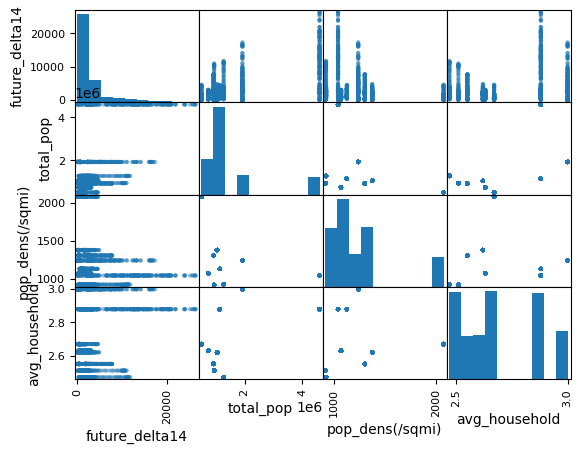

In [20]:
# Scatter plot for target with county features
pd.plotting.scatter_matrix(sparse[target + county_features])

array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='new_cases', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='total_cases', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='new_cases'>,
        <AxesSubplot: xlabel='new_cases', ylabel='new_cases'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='new_cases'>,
        <AxesSubplot: xlabel='total_cases', ylabel='new_cases'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='new_cases', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='total_cases', ylabel='past_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='total_cases'>,
        <AxesSubplot: xlabel='new_cases', ylabel='total_cases'>,
        <AxesSubplot: xlabel='past_delta14',

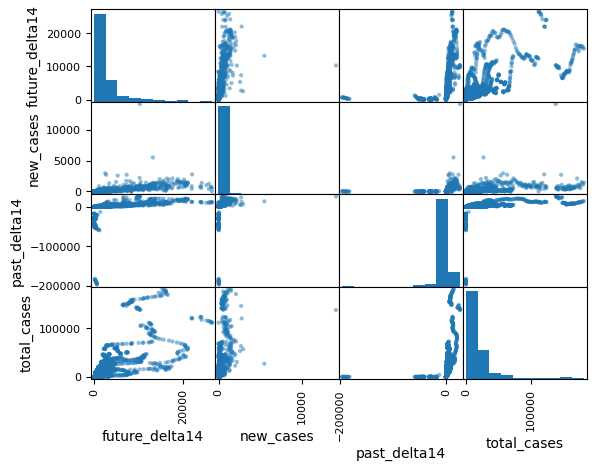

In [21]:
# Scatter plot for target with covid features
pd.plotting.scatter_matrix(sparse[target + covid_features])

array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='temp_mean(c)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='precip_sum(mm)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='wind_max(km/h)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='min_humidity(%)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='max_humidity(%)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='mean_humidity(%)', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='temp_mean(c)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='precip_sum(mm)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='wind_max(km/h)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='min_humidity(%)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='max_humidity(%)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='mean_humidity(%)', ylabel='tem

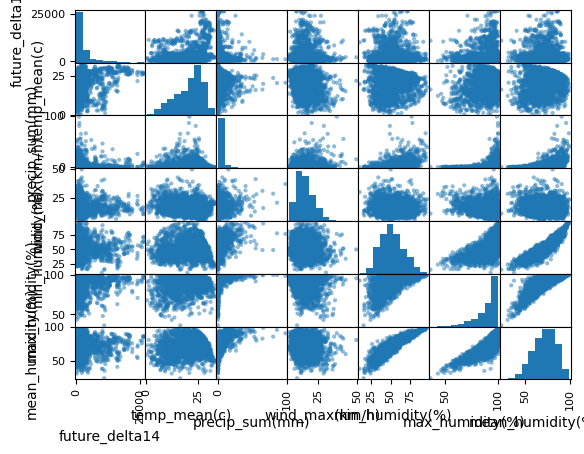

In [22]:
# Scatter plot for target with weather features
pd.plotting.scatter_matrix(sparse[target + weather_features])

## Dense County Data

In [23]:
# Dense Data Summary Statistics
dense.describe()

,future_delta14,temp_mean(c),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%),total_pop,pop_dens(/sqmi),avg_household,new_cases,past_delta14,total_cases
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1.567000e+03,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,4122.616465,16.886981,3.465667,19.103701,56.436503,88.373325,73.276324,1.590729e+06,2190.909381,2.701844,270.991066,-153.195278,30154.908743
std,8537.648319,7.613244,7.687219,7.141053,15.153355,10.187345,12.272173,1.810085e+06,379.878895,0.192745,604.653140,30189.837856,42375.505865
min,-174.000000,-13.000000,0.000000,6.700000,25.000000,46.000000,35.000000,2.455920e+05,1779.000000,2.480000,-168.000000,-325689.000000,1.000000
25%,397.000000,11.000000,0.000000,14.000000,45.000000,83.000000,65.000000,5.530660e+05,1840.000000,2.490000,23.000000,326.000000,4811.000000
50%,1188.000000,17.700000,0.100000,17.700000,56.000000,92.000000,74.000000,7.935550e+05,2134.000000,2.610000,70.000000,1031.000000,17189.000000
75%,4423.000000,23.400000,3.200000,22.800000,67.000000,96.000000,83.000000,1.356564e+06,2430.000000,2.890000,257.000000,3106.000000,39180.500000
max,63307.000000,31.500000,72.800000,68.400000,95.000000,100.000000,98.000000,5.223719e+06,2932.000000,3.000000,6697.000000,63307.000000,277026.000000


In [24]:
# Dense Weather Stats
dense[weather_features].describe()

,temp_mean(c),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%)
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,16.886981,3.465667,19.103701,56.436503,88.373325,73.276324
std,7.613244,7.687219,7.141053,15.153355,10.187345,12.272173
min,-13.000000,0.000000,6.700000,25.000000,46.000000,35.000000
25%,11.000000,0.000000,14.000000,45.000000,83.000000,65.000000
50%,17.700000,0.100000,17.700000,56.000000,92.000000,74.000000
75%,23.400000,3.200000,22.800000,67.000000,96.000000,83.000000
max,31.500000,72.800000,68.400000,95.000000,100.000000,98.000000


In [25]:
# Dense County Stats
dense[county_features].describe()

,total_pop,pop_dens(/sqmi),avg_household
count,1.567000e+03,1567.000000,1567.000000
mean,1.590729e+06,2190.909381,2.701844
std,1.810085e+06,379.878895,0.192745
min,2.455920e+05,1779.000000,2.480000
25%,5.530660e+05,1840.000000,2.490000
50%,7.935550e+05,2134.000000,2.610000
75%,1.356564e+06,2430.000000,2.890000
max,5.223719e+06,2932.000000,3.000000


In [26]:
# Dense Covid Stats
dense[covid_features].describe()

,new_cases,past_delta14,total_cases
count,1567.000000,1567.000000,1567.000000
mean,270.991066,-153.195278,30154.908743
std,604.653140,30189.837856,42375.505865
min,-168.000000,-325689.000000,1.000000
25%,23.000000,326.000000,4811.000000
50%,70.000000,1031.000000,17189.000000
75%,257.000000,3106.000000,39180.500000
max,6697.000000,63307.000000,277026.000000


In [27]:
dense.corr()

,future_delta14,temp_mean(c),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%),total_pop,pop_dens(/sqmi),avg_household,new_cases,past_delta14,total_cases
future_delta14,1.000000,-0.294011,-0.017345,0.225415,0.023480,-0.176954,-0.076889,0.574332,-0.040231,-0.061663,0.914409,0.249740,0.749266
temp_mean(c),-0.294011,1.000000,0.036660,-0.338661,0.062521,0.293416,0.204029,-0.286672,0.018483,-0.080636,-0.250014,0.081812,0.015393
precip_sum(mm),-0.017345,0.036660,1.000000,0.284280,0.406541,0.312930,0.423381,-0.036322,0.014820,-0.047630,-0.017465,0.008032,-0.047452
wind_max(km/h),0.225415,-0.338661,0.284280,1.000000,-0.065592,-0.283783,-0.206035,0.164436,-0.093047,0.070951,0.215346,0.064866,0.141017
min_humidity(%),0.023480,0.062521,0.406541,-0.065592,1.000000,0.560460,0.891840,0.151647,-0.115837,-0.053054,0.009105,0.037648,0.061137
max_humidity(%),-0.176954,0.293416,0.312930,-0.283783,0.560460,1.000000,0.829549,-0.128614,0.052827,-0.020485,-0.170874,0.008387,-0.157460
mean_humidity(%),-0.076889,0.204029,0.423381,-0.206035,0.891840,0.829549,1.000000,0.003563,-0.042923,-0.040759,-0.084693,0.023216,-0.051852
total_pop,0.574332,-0.286672,-0.036322,0.164436,0.151647,-0.128614,0.003563,1.000000,-0.090464,-0.096468,0.528641,0.173788,0.664943
pop_dens(/sqmi),-0.040231,0.018483,0.014820,-0.093047,-0.115837,0.052827,-0.042923,-0.090464,1.000000,-0.417525,-0.037562,0.023481,-0.100688
avg_household,-0.061663,-0.080636,-0.047630,0.070951,-0.053054,-0.020485,-0.040759,-0.096468,-0.417525,1.000000,-0.055170,-0.088340,0.054807


array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='total_pop', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='pop_dens(/sqmi)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='avg_household', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='total_pop'>,
        <AxesSubplot: xlabel='total_pop', ylabel='total_pop'>,
        <AxesSubplot: xlabel='pop_dens(/sqmi)', ylabel='total_pop'>,
        <AxesSubplot: xlabel='avg_household', ylabel='total_pop'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='pop_dens(/sqmi)'>,
        <AxesSubplot: xlabel='total_pop', ylabel='pop_dens(/sqmi)'>,
        <AxesSubplot: xlabel='pop_dens(/sqmi)', ylabel='pop_dens(/sqmi)'>,
        <AxesSubplot: xlabel='avg_household', ylabel='pop_dens(/sqmi)'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='avg_household'>,
        <AxesSubplot: xlabel='total_pop', ylabel='avg_household'>,
        <Axes

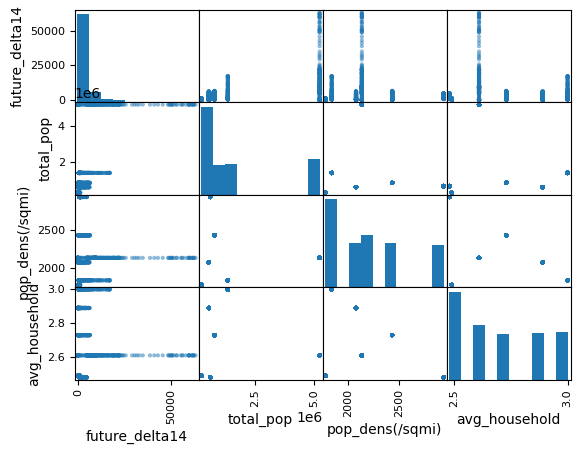

In [28]:
# Scatter plot for target with county features
pd.plotting.scatter_matrix(dense[target + county_features])

array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='new_cases', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='total_cases', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='new_cases'>,
        <AxesSubplot: xlabel='new_cases', ylabel='new_cases'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='new_cases'>,
        <AxesSubplot: xlabel='total_cases', ylabel='new_cases'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='new_cases', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='total_cases', ylabel='past_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='total_cases'>,
        <AxesSubplot: xlabel='new_cases', ylabel='total_cases'>,
        <AxesSubplot: xlabel='past_delta14',

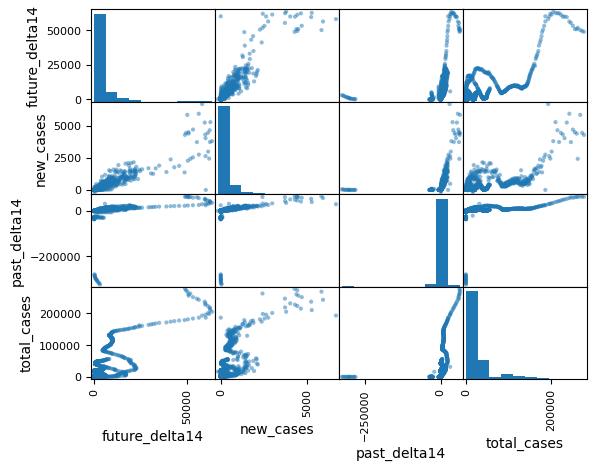

In [29]:
# Scatter plot for target with covid features
pd.plotting.scatter_matrix(dense[target + covid_features])

array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='temp_mean(c)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='precip_sum(mm)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='wind_max(km/h)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='min_humidity(%)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='max_humidity(%)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='mean_humidity(%)', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='temp_mean(c)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='precip_sum(mm)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='wind_max(km/h)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='min_humidity(%)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='max_humidity(%)', ylabel='temp_mean(c)'>,
        <AxesSubplot: xlabel='mean_humidity(%)', ylabel='tem

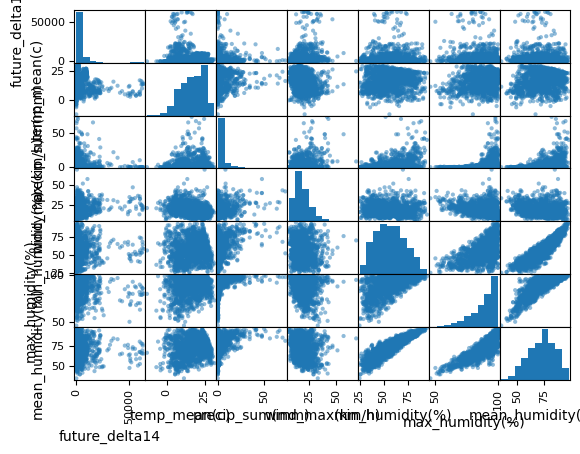

In [30]:
# Scatter plot for target with weather features
pd.plotting.scatter_matrix(dense[target + weather_features])